## Data importing

### Download data

From [this query on Quarry](https://quarry.wmflabs.org/query/17277), which is:

```sql
SELECT reverted.*, page.page_title, page.page_is_redirect, revision.rev_comment 
FROM u2041__botvbot_p.enwiki_bot2bot_reverted_20140820 as reverted
LEFT JOIN page on rev_page = page_id
LEFT JOIN revision on reverted.reverting_id = revision.rev_id
```

This joins halfak's bot2bot revert table with page and revision to get page titles and edit comments.

In [1]:
!wget https://quarry.wmflabs.org/run/163640/output/0/tsv?download=true -O botvbot-enwiki-comments.tsv

--2017-03-24 13:55:33--  https://quarry.wmflabs.org/run/163640/output/0/tsv?download=true
Resolving quarry.wmflabs.org (quarry.wmflabs.org)... 208.80.155.156
Connecting to quarry.wmflabs.org (quarry.wmflabs.org)|208.80.155.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘botvbot-enwiki-comments.tsv’

botvbot-enwiki-comm     [    <=>             ] 156.72M  4.36MB/s    in 34s     

2017-03-24 13:56:07 (4.63 MB/s) - ‘botvbot-enwiki-comments.tsv’ saved [164330289]



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set()

pd.options.display.max_columns = 50

### Import to pandas dataframe

In [3]:
df = pd.read_csv("botvbot-enwiki-comments.tsv", sep="\t", encoding="utf-8")

In [4]:
len(df)

480329

In [5]:
print(df.columns)

Index(['rev_id', 'rev_timestamp', 'rev_user', 'rev_user_text', 'rev_page',
       'rev_sha1', 'rev_minor_edit', 'rev_deleted', 'rev_parent_id',
       'archived', 'reverting_id', 'reverting_timestamp', 'reverting_user',
       'reverting_user_text', 'reverting_page', 'reverting_sha1',
       'reverting_minor_edit', 'reverting_deleted', 'reverting_parent_id',
       'reverting_archived', 'rev_revert_offset', 'revisions_reverted',
       'reverted_to_rev_id', 'page_namespace', 'page_title',
       'page_is_redirect', 'rev_comment'],
      dtype='object')


## Data processing
### Create field for deleted revisions

In [6]:
df['is_deleted'] = np.where(df.rev_comment.isnull(), 1, 0)
df['is_deleted'].value_counts()

0    464229
1     16100
Name: is_deleted, dtype: int64

### Create datetime index based on date of reverting edit

In [7]:
df['reverting_timestamp_dt'] = pd.to_datetime(df['reverting_timestamp'], format="%Y%m%d%H%M%S")
df = df.set_index('reverting_timestamp_dt')

### Create field for comment text with text in brackets and parentheses removed

In [8]:
# by http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python

def remove_brackets(test_str):
    test_str = str(test_str)
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
            
    return " ".join(ret.split())

In [9]:
df['rev_comment_nobracket'] = df['rev_comment'].apply(remove_brackets)

### Create second dataset for ns0 / articles only

In [10]:
df_ns0 = df[df['page_namespace'] == 0].copy()

## Exploratory analysis

### Most frequent comments in ns0 reverts, with text in brackets & parens removed

In [11]:
other_count = 0
for comment, count in df_ns0['rev_comment_nobracket'].value_counts().iteritems():
    if count > 100:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

55356 	 Migrating 1 interwiki links, now provided by on
46156 	 Robot: Fixing double redirect to
13654 	 Bot: Fixing double redirect to
12481 	 Migrating 2 interwiki links, now provided by on
10061 	 Robot: Fixing double redirect
7889 	 r2.7.1)
6708 	 robot Modifying:
5269 	 Migrating 3 interwiki links, now provided by on
4752 	 robot Removing:
3821 	 Fixing identified double redirect
3545 	 nan
3297 	 r2.6.4)
3054 	 r2.7.2)
2971 	 r2.7.3)
2965 	 Bot: Migrating 1 interwiki links, now provided by on
2840 	 Bot: Migrating 1 langlinks, now provided by Wikidata on
2631 	 removing a protection template from a non-protected page
2574 	 robot Adding:
1908 	 has been moved; it now redirects to .
1192 	 r2.7.2+)
1189 	 r2.5.5)
822 	 r2.6.5)
761 	 Migrating 4 interwiki links, now provided by on
704 	 removing non-applicable orphan template
577 	 r2.5.2)
562 	 Robot: moving pages out of redirected category
532 	 Daily update. See for changes.
528 	 Fixing double redirect
513 	 : Fixing double red

## Categorizing types of bot activity based on comments

### Check for having a language code in between punctuation

In [12]:
def interwiki_confirm(comment):
    """
    Takes a comment string, searches for language codes bordered by 
    two punctuation marks from [](){},: or one punctuation mark and
    one space. Beginning and end of a comment string counts as a
    space, not a punctuation mark.
    """
    import string, re
    
    with open("lang_codes.tsv", "r") as f:
        lang_codes = f.read().split("\n")
        
    lang_codes.pop() # a blank '' is in the list that gets returned
    
    try:
        comment = str(comment)
        comment = comment.lower()
        comment = " " + comment + " "  # pad start and end of string with non-punctuation
        
    except Exception as e:
        return 'other'
    
    for lang_code in lang_codes:
        
        lang_code_pos = comment.find(lang_code)
        lang_code_len = len(lang_code)
        
        char_before = " "
        char_after = " "
        
        if lang_code_pos >= 0:
            char_before = comment[lang_code_pos-1]
        
            #print("Char before: '", char_before, "'", sep='')
             
            char_after = comment[lang_code_pos+lang_code_len]

            #print("Char after: '", char_after, "'", sep='')
            
            if char_before in string.punctuation and char_after in "[]{}(),:":
                #print(lang_code)
                return 'interwiki link cleanup -- suspected'
            
            elif char_before in string.punctuation and char_after == "[]{}(),:":
                #print(lang_code)
                return 'interwiki link cleanup -- suspected'
            
            elif char_before == " " and char_after in "[]{}(),:":
                #print(lang_code)
                return 'interwiki link cleanup -- suspected'


               
    return 'other'
    

#### Testing interwiki parser

In [13]:
tests_yes = ["Robot adding [[es:Test]]", "adding es:Test", "linking es, it, en"]
tests_no = ["test", "discuss policies on enwiki vs eswiki", "it is done", "it's not its", "its not it's"]

print("Should return interwiki link cleanup -- suspected")
for test in tests_yes:
    print("\t", interwiki_confirm(test))

print("Should return other")
for test in tests_no:
    print("\t", interwiki_confirm(test))

Should return interwiki link cleanup -- suspected
	 interwiki link cleanup -- suspected
	 interwiki link cleanup -- suspected
	 interwiki link cleanup -- suspected
Should return other
	 other
	 other
	 other
	 other
	 other


### Comment parser

In [14]:
def comment_categorization(row):
    """
    Takes a row from a pandas dataframe or dict and returns a string with a
    kind of activity based on metadata. Used with df.apply(). Mostly parses
    comments, but makes some use of usernames too.
    """
    
    reverting_user = str(row['reverting_user_text'])
    
    
    if reverting_user.find("HBC AIV") >= 0:
        return 'AIV helperbot'
    
    try:
        comment = str(row['rev_comment'])
    except Exception as e:
        return 'other'
    
    comment_lower = comment.lower().strip()
    comment_lower = " ".join(comment_lower.split())
 
    if comment == 'nan':
        return "deleted revision"
    
    elif comment.find("Undoing massive unnecessary addition of infoboxneeded by a (now blocked) bot") >= 0:
        return "botfight: infoboxneeded"
    
    elif comment_lower.find("commonsdelinker") >=0 and reverting_user.find("CommonsDelinker") == -1:
        return "botfight: reverting CommonsDelinker"
        
    elif comment.find("Reverted edits by [[Special:Contributions/ImageRemovalBot") >= 0:
        return "botfight: 718bot vs ImageRemovalBot"
    
    elif comment_lower.find("double redirect") >= 0:
        return "fixing double redirect"
    
    elif comment_lower.find("double-redirect") >= 0:
        return "fixing double redirect"

    elif comment_lower.find("has been moved; it now redirects to") >= 0:
        return "fixing double redirect"
        
    elif comment_lower.find("redirect tagging") >= 0:
        return "redirect tagging/sorting"
    
    elif comment_lower.find("sorting redirect") >= 0:
        return "redirect tagging/sorting"
    
    elif comment_lower.find("change redirected category") >= 0:
        return "category redirect cleanup"
    
    elif comment_lower.find("redirected category") >=0:
        return "category redirect cleanup"
    
    elif comment.find("[[User:Addbot|Bot:]] Adding ") >= 0:
        return "template tagging"
    
    elif comment_lower.find("interwiki") >= 0:
        return "interwiki link cleanup"
    
    elif comment_lower.find("langlinks") >= 0:
        return "interwiki link cleanup"
    
    elif comment_lower.find("iw-link") >= 0:
        return "interwiki link cleanup"
    
    elif comment_lower.find("changing category") >= 0:
        return "moving category"
    
    elif comment_lower.find("recat per") >= 0:
        return "moving category"
    
    elif comment_lower.find("moving category") >= 0:
        return "moving category"
    
    elif comment_lower.find("re-categorisation") >= 0:
        return "moving category"
    
    elif comment_lower.find("removing a protection template") >= 0:
        return "protection template cleanup"
    
    elif comment_lower.find("removing categorization template") >= 0:
        return "template cleanup"    
    
    elif comment_lower.find("rm ibid template per") >= 0:
        return "template cleanup"      
    
    elif comment_lower.find("page is not protected") >= 0:
        return "template cleanup"          
    
    elif comment_lower.find("removing protection template") >= 0:
        return "template cleanup"      
    
    elif comment_lower.find("removing orphan t") >= 0:
        return "orphan template cleanup"
    
    elif comment_lower.find("non-applicable orphan") >= 0:
        return "orphan template cleanup"
    
    elif comment_lower.find("removed orphan t") >= 0:
        return "orphan template cleanup"    
    
    elif comment_lower.find("sandbox") >= 0:
        return "clearing sandbox"
    
    elif comment_lower.find("archiving") >= 0:
        return "archiving"
    
    elif comment_lower.find("duplicate on commons") >= 0:
        return "commons image migration"
    
    elif comment_lower.find("user:mathbot/changes to mathlists") >= 0:
        return "mathbot mathlist updates"
        
    elif comment_lower.find("link syntax") >= 0:
        return "link syntax fixing"
    
    elif comment_lower.find("links syntax") >= 0:
        return "link syntax fixing" 
    
    elif comment_lower.find(" per") >= 0:
        return "other w/ per justification"  
    
    elif comment_lower.find("revert") >= 0:
        return "other w/ revert in comment"  
    
    elif comment_lower.find("rv ") >= 0 or comment_lower.find("rv") == 0:
        return "other w/ revert in comment"  
    
    else:
        return interwiki_confirm(comment)

### Apply categorization

In [15]:
df['bottype'] = df.apply(comment_categorization, axis=1)
df_ns0['bottype'] = df_ns0.apply(comment_categorization, axis=1)

### Set type to "other redirect" for other cases on redirect pages

In [16]:
df.loc[(df['bottype'] == 'other') & (df['page_is_redirect'] == 1), ['bottype']] = 'other redirect'
df_ns0.loc[(df_ns0['bottype'] == 'other') & (df_ns0['page_is_redirect'] == 1), ['bottype']] = 'other redirect'

# Analysis

## Types of bot-vs-bot reverts across all namespaces

In [17]:
type_counts = df['bottype'].value_counts().rename("count")
type_percent = df['bottype'].value_counts(normalize=True).rename("percent") * 100
type_percent = type_percent.round(2).astype(str) + "%"

pd.concat([type_counts, type_percent], axis=1)

,count,percent
interwiki link cleanup,180293,37.54%
fixing double redirect,90013,18.74%
AIV helperbot,77390,16.11%
interwiki link cleanup -- suspected,52644,10.96%
other w/ per justification,19761,4.11%
deleted revision,16046,3.34%
other,15965,3.32%
archiving,8268,1.72%
clearing sandbox,5080,1.06%
other w/ revert in comment,3992,0.83%


### Plot

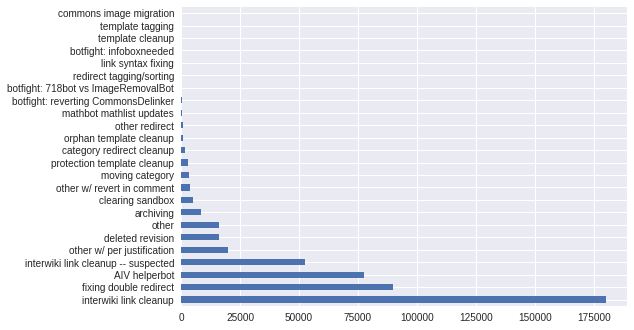

In [18]:
df['bottype'].value_counts().plot(kind='barh')

## Types of bot-vs-bot reverts in ns0 / articles

In [19]:
type_counts = df_ns0['bottype'].value_counts().rename("count")
type_percent = df_ns0['bottype'].value_counts(normalize=True).rename("percent") * 100
type_percent = type_percent.round(2).astype(str) + "%"

pd.concat([type_counts, type_percent], axis=1)

,count,percent
interwiki link cleanup,82244,38.3%
fixing double redirect,81907,38.14%
interwiki link cleanup -- suspected,35608,16.58%
deleted revision,3545,1.65%
protection template cleanup,2631,1.23%
other,2116,0.99%
moving category,1987,0.93%
orphan template cleanup,1020,0.48%
category redirect cleanup,977,0.45%
other w/ revert in comment,519,0.24%


### Plot

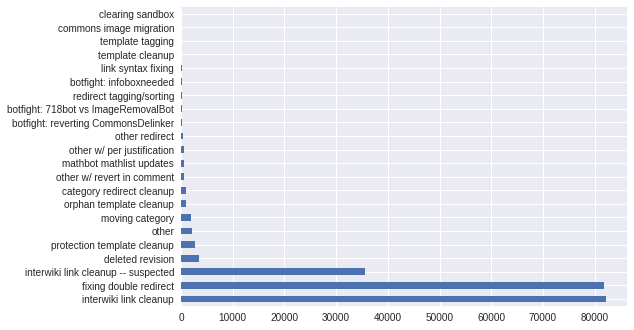

In [20]:
df_ns0['bottype'].value_counts().plot(kind='barh')

## Timeseries visualizations

### All namespaces plot of bot-vs-bot reverts over time, grouped weekly

In [21]:
gb_all = df.groupby([pd.TimeGrouper('1W', closed='left')])

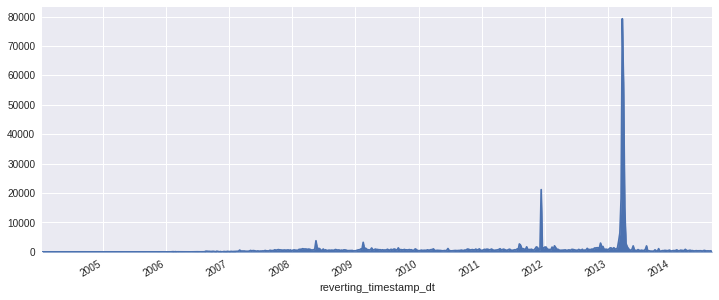

In [22]:
ax1 = gb_all.rev_id.count().plot(kind='area', figsize=[12,5])

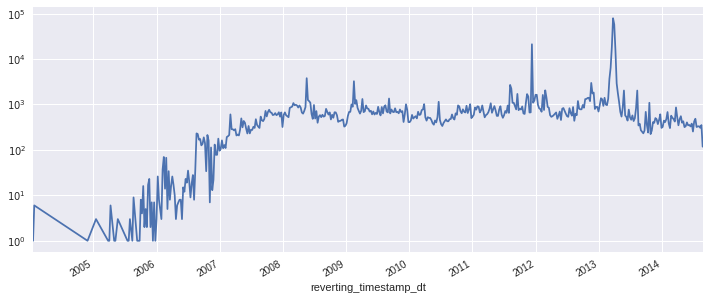

In [23]:
ax1 = gb_all.rev_id.count().plot(kind='line', figsize=[12,5], logy=True)

### Article / ns0 plot of bot-vs-bot reverts over time, grouped weekly

In [24]:
gb_ns0 = df_ns0.groupby([pd.TimeGrouper('1W', closed='left')])

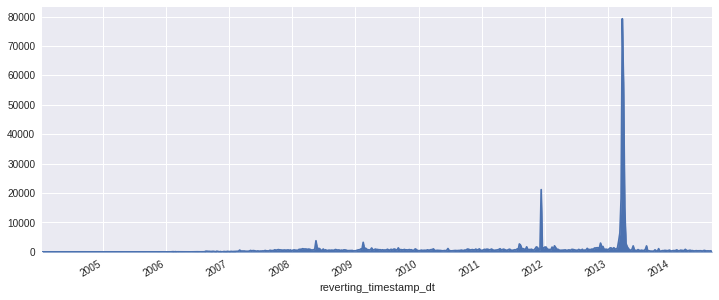

In [25]:
ax1 = gb_all.rev_id.count().plot(kind='area', figsize=[12,5])

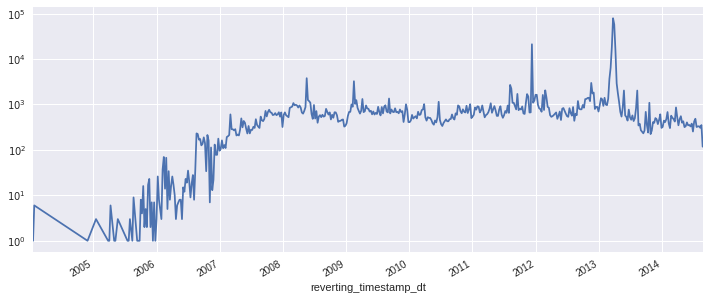

In [26]:
ax1 = gb_all.rev_id.count().plot(kind='line', figsize=[12,5], logy=True)

### Group by daily counts for each bot type, all namespaces

In [27]:
gp = df.groupby([pd.TimeGrouper('1D', closed='left'), 'bottype'])

### Subplots by bot type, no shared y axis

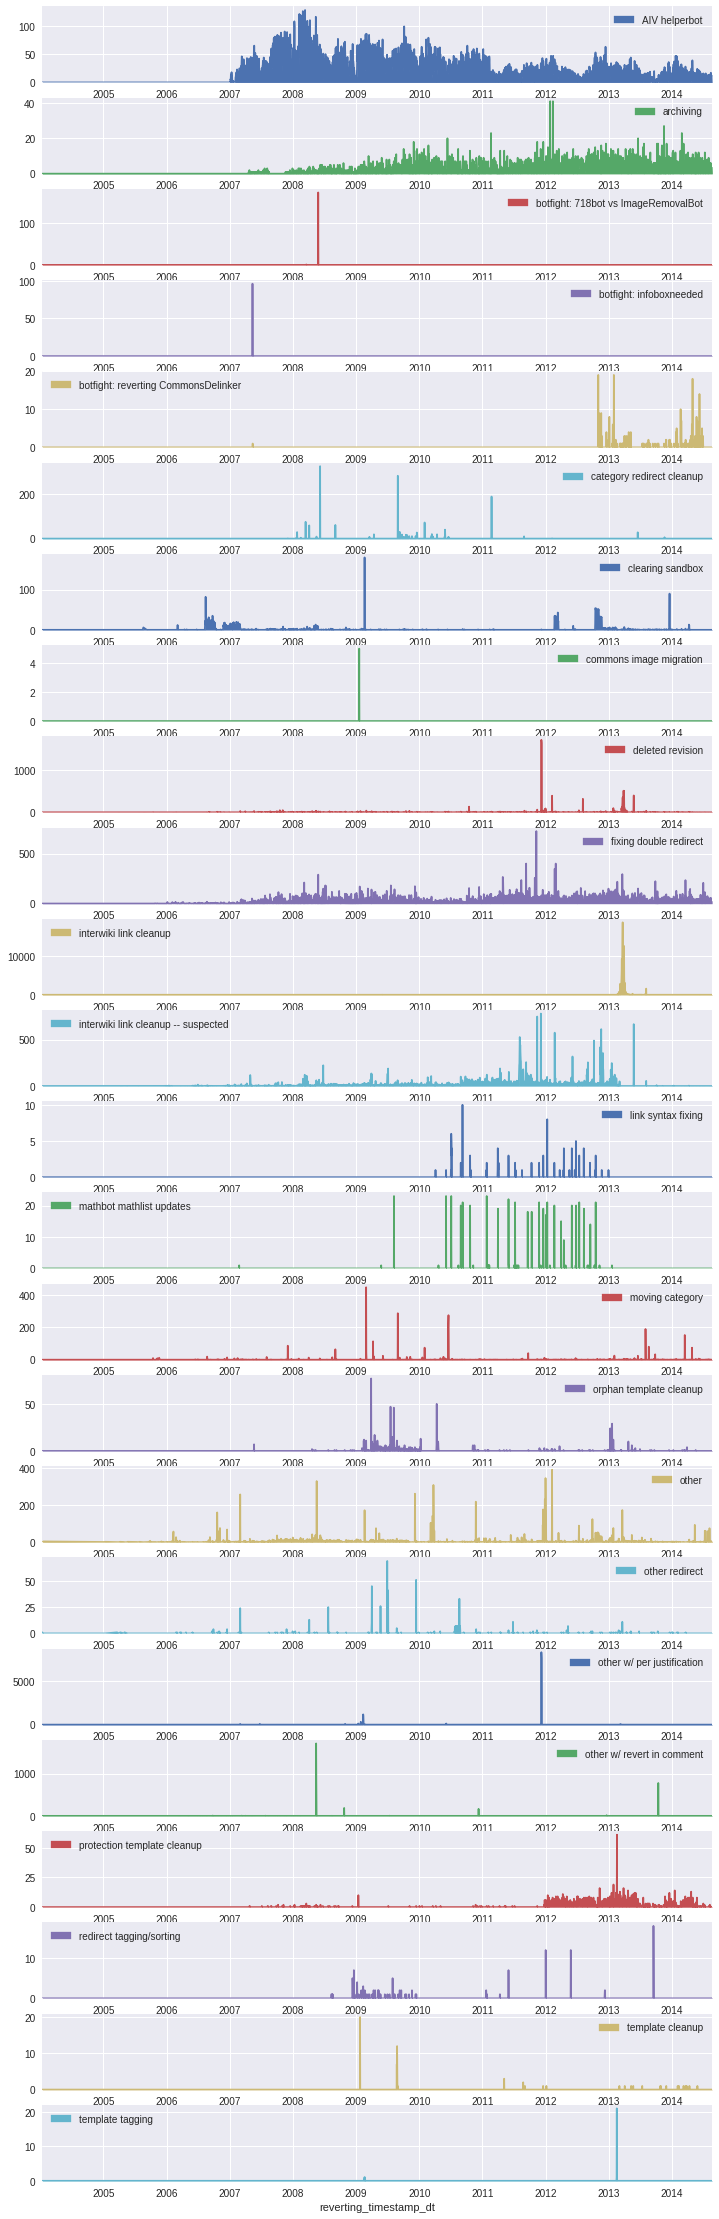

In [28]:
ax1 = gp.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,40], sharex=False)

### Subplots by bot type, shared y axis

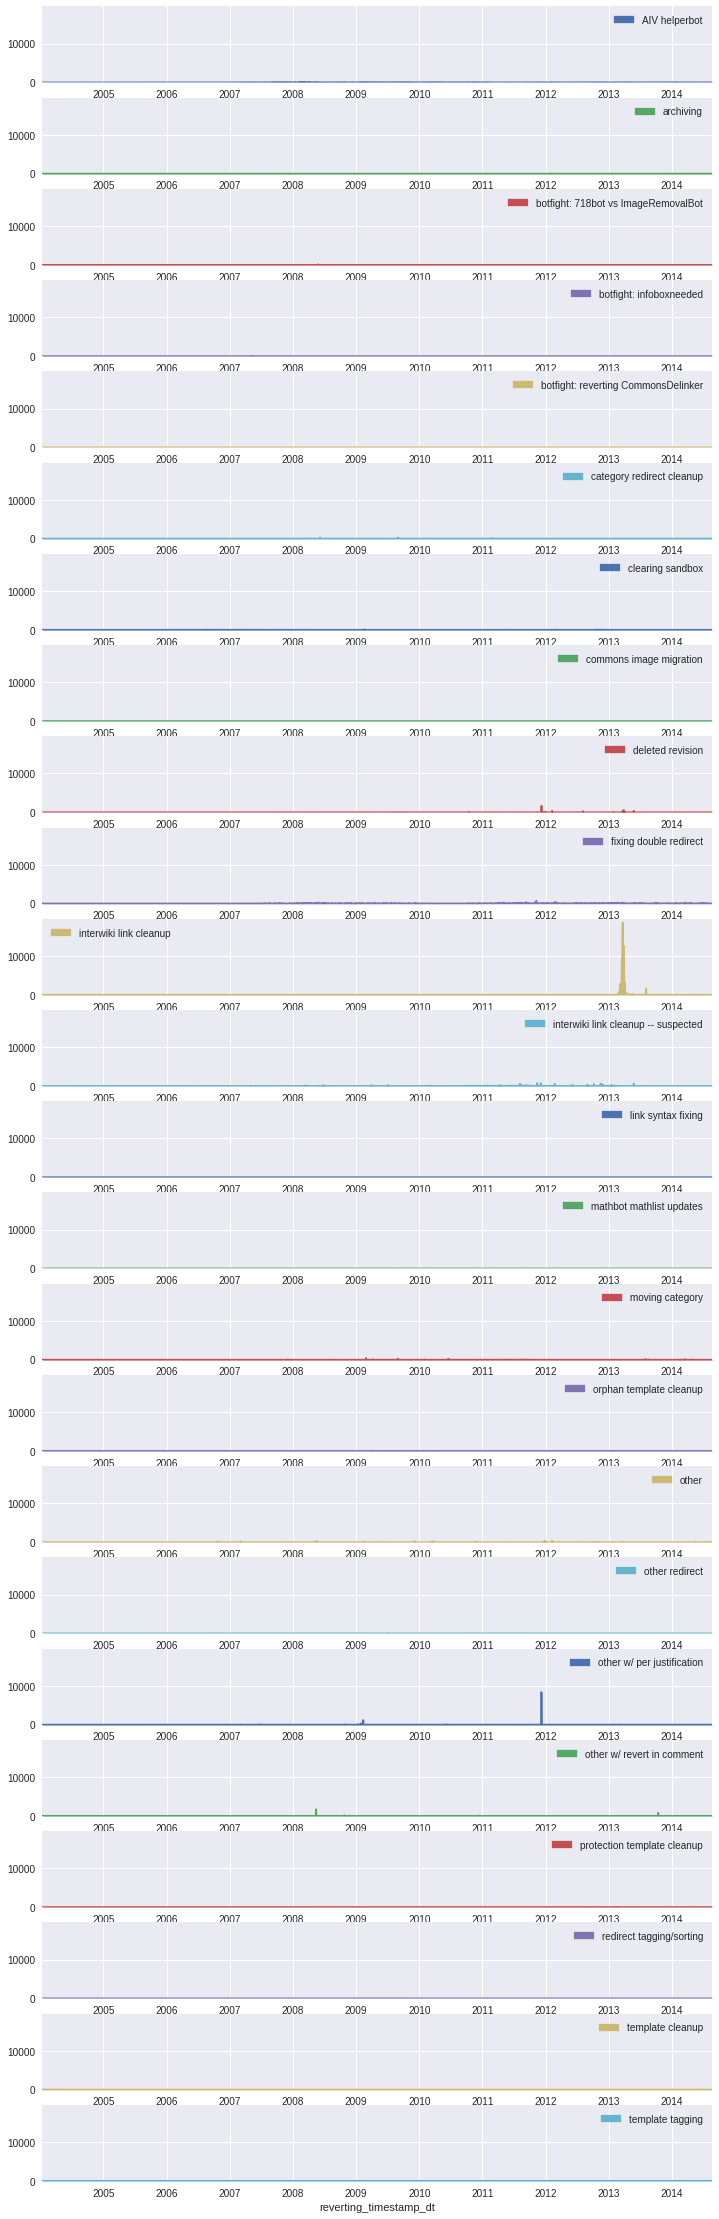

In [29]:
ax2 = gp.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,40], sharex=False, sharey=True)

### Group by daily counts for each bot type, ns0 / articles only

In [30]:
gp_ns0 = df_ns0.groupby([pd.TimeGrouper('1D', closed='left'), 'bottype'])

### Subplots by bot type, no shared y axis

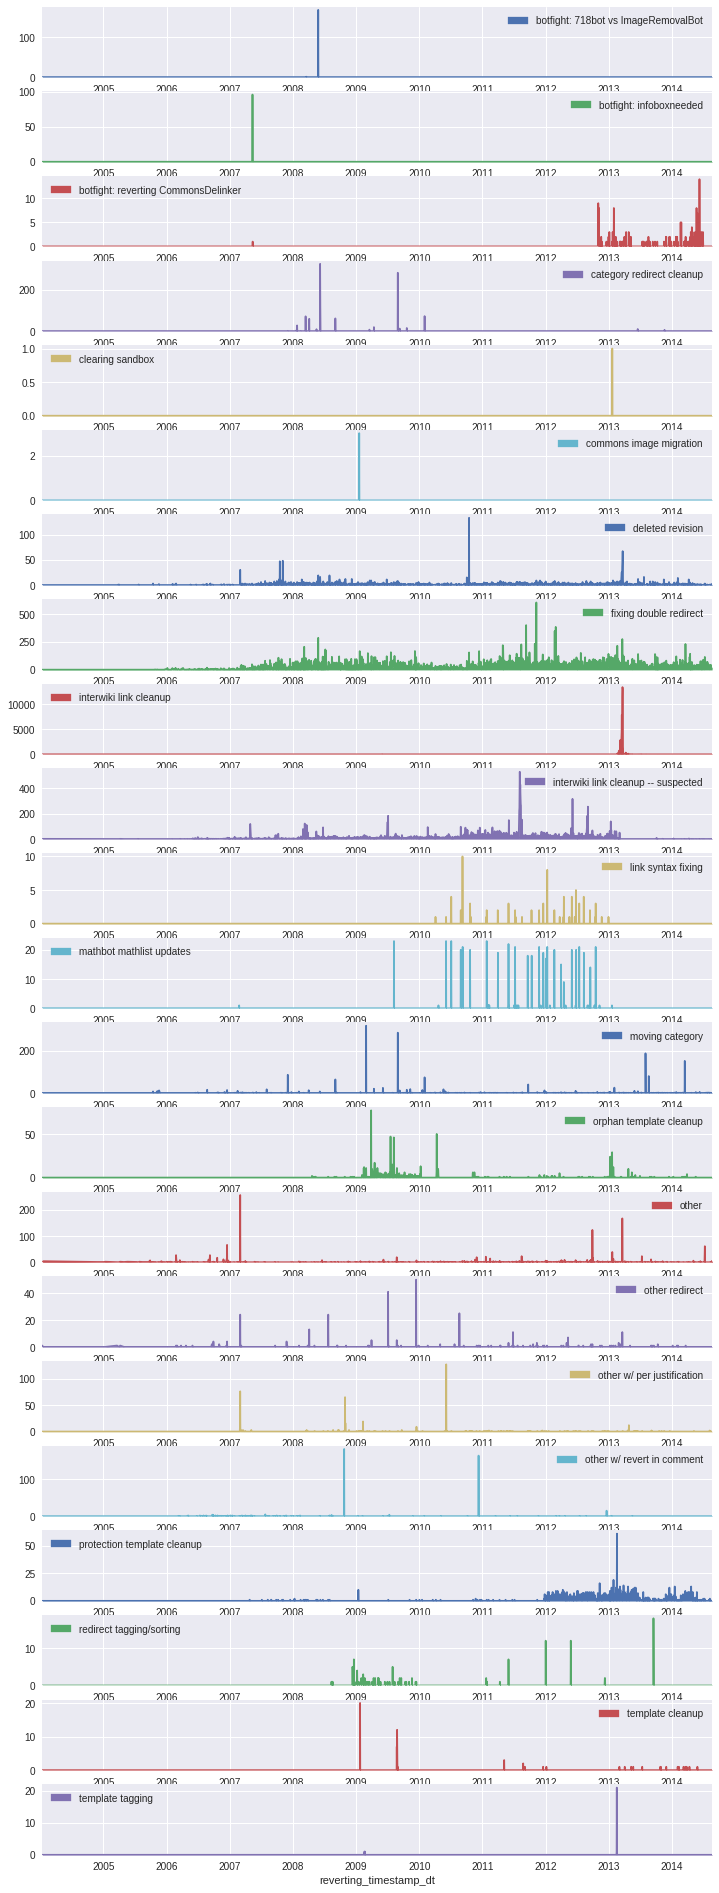

In [31]:
ax3 = gp_ns0.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,34], sharex=False)

### Subplots by bot type, shared y axis

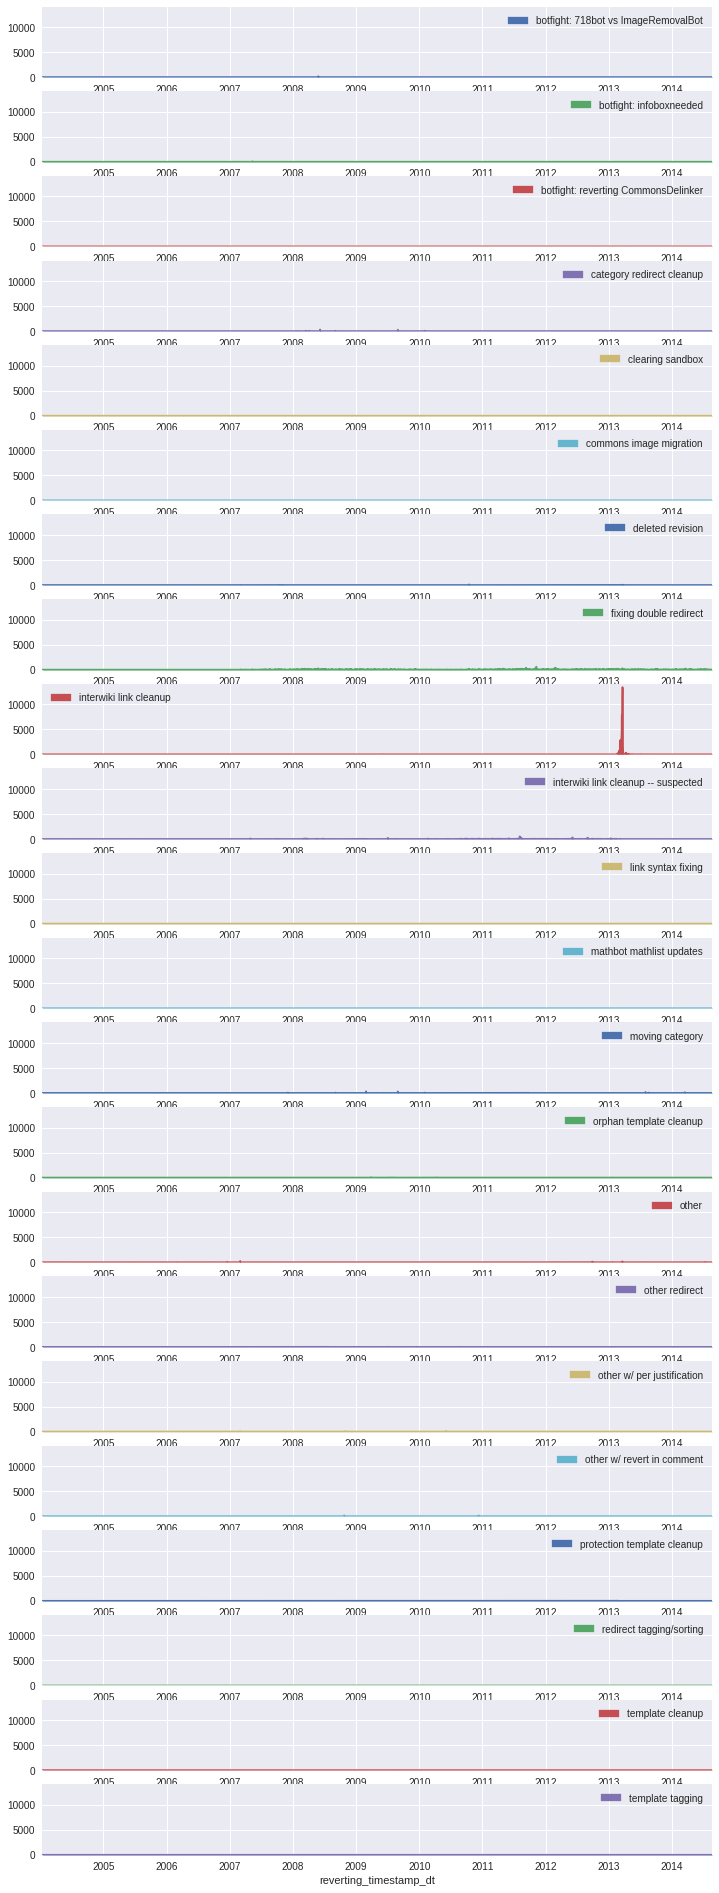

In [32]:
ax4 = gp_ns0.rev_id.count().unstack().plot(kind='area', subplots=True, figsize=[12,34], sharex=False, sharey=True)

## What wasn't categorized in ns0?

In [33]:
other_count = 0
for comment, count in df_ns0[df_ns0['bottype']=='other']['rev_comment'].value_counts().iteritems():
    if count > 10:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

253 	 Correcting template, Replaced: {{4CC → {{disambig  using [[Project:AWB|AWB]]
149 	 removing incominglinks template; fewer than 25 links
66 	 Add category Rockaway, Queens that was inadvertently deleted  using [[Project:AWB|AWB]]
36 	 [[WP:CHECKWIKI]] error fixes using [[Project:AWB|AWB]] (10300)
27 	 BOT - automated removal of category [[Category:Filipino singers|Filipino singers]]
27 	 Robot: Changing template: corp-stub
24 	 /* References */[[WP:CHECKWIKI]] error fixes using [[Project:AWB|AWB]] (10300)
21 	 Fixed/removed {{expand}} + [[WP:CHECKWIKI]] error fixes + [[WP:GENFIXES|general fixes]], removed expand tag using [[Project:AWB|AWB]] (7552)
17 	 Daily update. See [[User:Mathbot/Changes mathlist]] for changes.
14 	 /* External links */[[WP:CHECKWIKI]] error fixes using [[Project:AWB|AWB]] (9345)
13 	 Bot: category redirect - changing [[:Category:English businesspeople]] to [[:Category:English business people]]
12 	 Tag/Date tags and general  fixes, added [[:Category:Categor

In [34]:
other_count = 0
for comment, count in df_ns0[df_ns0['bottype']=='other']['rev_comment_nobracket'].value_counts().iteritems():
    if count > 10:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

253 	 Correcting template, Replaced: {{4CC → {{disambig using
252 	 r2.7.1)
149 	 removing incominglinks template; fewer than 25 links
145 	 Перемещение 1 интервики-ссылки в Викиданные
109 	 r2.7.3)
99 	 robot Modifying:
92 	 r2.7.2)
86 	 robot Removing:
66 	 Add category Rockaway, Queens that was inadvertently deleted using
50 	 error fixes using
36 	 /* References */ error fixes using
35 	 robot Adding:
27 	 Robot: Changing template: corp-stub
27 	 BOT - automated removal of category
26 	 r2.6.4)
23 	 /* External links */ error fixes using
21 	 Перемещение 2 интервики-ссылок в Викиданные
21 	 Fixed/removed {{expand}} + error fixes + , removed expand tag using
19 	 /* External links */ error fixes + using
17 	 r2.6.5)
17 	 Daily update. See for changes.
13 	 r2.7.2+)
13 	 Bot: category redirect - changing to
13 	 /* External links */ error fix for #17. Category duplication. Do if a problem exists. - using
13 	 Removing links to deleted file
12 	 error fixes + using
12 	 Tag/Date tags 

In [35]:
other_count = 0
for comment, count in df[df['bottype']=='other']['reverting_user_text'].value_counts().iteritems():
    if count > 25:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

3289 	 ClueBot II
1966 	 Fbot
1838 	 AvicBot2
850 	 Yobot
828 	 Xenobot
731 	 WildBot
663 	 Svenbot
463 	 Shadowbot3
432 	 AnomieBOT
316 	 John Bot
270 	 Ganeshbot
253 	 STBot
252 	 EmausBot
207 	 Addbot
177 	 Yetanotherbot
167 	 JAnDbot
153 	 ContinuityBot
153 	 DPL bot
144 	 Werdnabot
129 	 ListasBot
128 	 Chris G Bot 3
122 	 LivingBot
119 	 EdwardsBot
103 	 SoxBot II
97 	 ZéroBot
74 	 LostBot
70 	 SmackBot
67 	 DomBot
67 	 ChuispastonBot
61 	 Femto Bot
61 	 DHN-bot
60 	 Xqbot
52 	 VoABot II
51 	 OverlordQBot
46 	 ShepBot
43 	 Cydebot
37 	 DSisyphBot
36 	 MastiBot
34 	 WikitanvirBot
34 	 Hazard-Bot
31 	 FrescoBot
30 	 BG19bot
30 	 SoxBot V
29 	 Mathbot
28 	 TPO-bot
27 	 XyBot
26 	 MystBot
26 	 PixelBot
26 	 YurikBot
26 	 Erwin85Bot
1043 	Other cases


## Exploring rows

### ns0 rows classifed as 'other'

In [36]:
pd.options.display.max_rows = 1000
df_ns0[df_ns0['bottype'] == 'other'][['reverting_user_text', 'rev_user_text', 'rev_comment', 'page_is_redirect']]

,reverting_user_text,rev_user_text,rev_comment,page_is_redirect
reverting_timestamp_dt,,,,
2004-11-24 02:51:15,Jumbuck,Robbot,robot Modifying:fr,0.0
2005-07-15 07:01:19,YurikBot,Robbot,robot Adding: ru,0.0
2005-08-16 01:51:28,Zwobot,Robbot,robot Adding: eo,0.0
2009-08-24 03:17:43,Alexbot,Robbot,"robot Adding: [[ro:Râul Bogata, Moldova]]",0.0
2004-01-20 21:02:45,Robbot,Wikibot,Andre Engels - robot Removing:fi,0.0
2004-01-18 14:29:40,Robbot,Wikibot,Andre Engels - robot Removing:es,0.0
2004-01-20 20:42:11,Robbot,Wikibot,Andre Engels - robot Removing:da,0.0
2004-01-20 17:01:55,Robbot,Wikibot,Andre Engels - robot Removing:pl,0.0
2004-01-20 14:45:28,Robbot,Wikibot,Andre Engels - robot Removing:sv,0.0


### ns0 rows classified as suspected interwiki link cleanup

In [37]:
pd.options.display.max_rows = 1000
df_ns0[df_ns0['bottype'] == 'interwiki link cleanup -- suspected'][['reverting_user_text', 'rev_user_text', 'rev_comment', 'page_is_redirect']]

,reverting_user_text,rev_user_text,rev_comment,page_is_redirect
reverting_timestamp_dt,,,,
2005-07-20 16:29:05,HasharBot,Robbot,"robot Adding: ca, fr",0.0
2006-07-22 23:32:16,YurikBot,Robbot,robot Modifying: [[fr:Impôt en France]],0.0
2006-07-24 07:35:29,YurikBot,Robbot,robot Modifying: [[fr:Impôt en France]],0.0
2010-02-14 02:33:49,BOT-Superzerocool,Robbot,robot Modifying: [[ru:A Different Beat (альбом)]],0.0
2006-08-17 05:49:11,Vina-iwbot,Robbot,robot Removing: [[pl:E]],0.0
2006-08-17 06:32:45,Vina-iwbot,Robbot,robot Removing: [[pl:G]],0.0
2007-01-31 09:17:55,Thijs!bot,Robbot,robot Modifying: [[de:Xanadu]],0.0
2006-11-24 16:29:55,Thijs!bot,Robbot,robot Modifying: [[nl:Nishinomiya]],0.0
2008-08-28 21:58:57,Thijs!bot,Robbot,robot Adding: [[es:Madonne-et-Lamerey]],0.0


### ns0 rows classified as CommonsDelinker reverts

In [38]:
pd.options.display.max_rows = 1000
df_ns0[df_ns0['bottype'] == 'botfight: reverting CommonsDelinker'][['reverting_user_text', 'rev_user_text', 'rev_comment', 'page_is_redirect']]

,reverting_user_text,rev_user_text,rev_comment,page_is_redirect
reverting_timestamp_dt,,,,
2012-11-01 08:35:57,DcoetzeeBot,CommonsDelinker,Revert CommonsDelinker - incorrect removal of ...,0.0
2007-05-14 16:00:33,MartinBot,CommonsDelinker,BOT - rv [[Special:Contributions/CommonsDelink...,0.0
2013-04-04 07:46:16,Commons fair use upload bot,CommonsDelinker,Reverting incorrect removal by CommonsDelinker...,0.0
2014-06-29 05:00:38,Commons fair use upload bot,CommonsDelinker,Reverting incorrect removal by CommonsDelinker...,0.0
2014-06-09 02:20:47,Commons fair use upload bot,CommonsDelinker,Reverting incorrect removal by CommonsDelinker...,0.0
2014-02-20 23:40:51,Commons fair use upload bot,CommonsDelinker,Reverting incorrect removal by CommonsDelinker...,0.0
2014-02-24 09:20:47,Commons fair use upload bot,CommonsDelinker,Reverting incorrect removal by CommonsDelinker...,0.0
2014-01-27 11:10:24,Commons fair use upload bot,CommonsDelinker,Reverting incorrect removal by CommonsDelinker...,0.0
2014-04-23 21:40:22,Commons fair use upload bot,CommonsDelinker,Reverting incorrect removal by CommonsDelinker...,0.0


# Export

In [39]:
df.to_pickle("botvbot-enwiki-comments-allns-processed.pickle")
df.to_csv("botvbot-enwiki-comments-allns-processed.tsv", sep="\t")
df_ns0.to_pickle("botvbot-enwiki-comments-ns0-processed.pickle")
df_ns0.to_csv("botvbot-enwiki-comments-ns0-processed.tsv", sep="\t")